[View in Colaboratory](https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/mnist.ipynb)

In [3]:
!pip3 install torch torchvision

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('drive/My Drive/BScThesis')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=64
num_workers=1

In [11]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


Processing...
Done!


In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

7


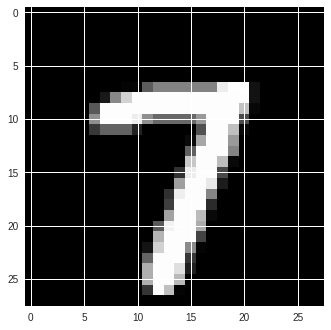

In [13]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
def test(model, device, test_loader, no_print=False):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1] 
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  if no_print:
    return test_loss, correct
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)


tensor(4)


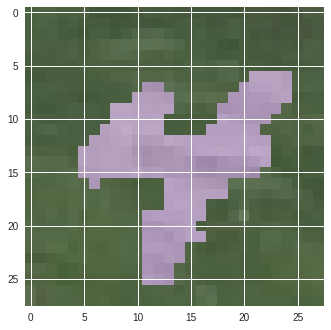

In [19]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)



In [0]:
class GradReverse(torch.autograd.Function):
    def __init__(self, lambd=1.):
      self.lambd = lambd
    
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output):
        return (grad_output * -self.lambd)

def grad_reverse(x, lambd):
    return GradReverse(lambd)(x)

In [0]:
class MnistDomain(nn.Module):
  def __init__(self):
    super(MnistDomain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x, lambd=1.):
    x = grad_reverse(x, lambd)
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1) 
    

In [0]:
class MnistFeatureExtractor(nn.Module):
  def __init__(self):
    super(MnistFeatureExtractor, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
  def forward(self, x):
    x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
    x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    return x.view(-1, 320) 

In [0]:
class MnistClassPredictor(nn.Module):
  def __init__(self):
    super(MnistClassPredictor, self).__init__()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)    

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
def concatDomainBatches(batches, shuffle=True):
  domain_num = np.arange(len(batches))[...,None]
  batch_len = len(batches[0])
  try:
    batches = torch.cat(batches).numpy()
  except:
    pass 
  domain_labels = (np.ones(batch_len) * domain_num).reshape(-1)
  if shuffle:
    idx = np.random.permutation(len(domain_labels))
    batches, domain_labels = batches[idx], domain_labels[idx].astype(np.long)
  return torch.from_numpy(batches), torch.from_numpy(domain_labels)

In [0]:
def trainWithDomain(model_f, model_c, model_d, device, train_loader_class, 
                    train_loader_domain, optim_f, optim_c, optim_d, 
                    epoch, epochs, use_lambd=True, train_domain=True,
                    train_history=defaultdict(lambda:[]), extra_loss=None):
  model_f.train()
  model_c.train()
  model_d.train()

  if train_domain:
    domain_iter = iter(train_loader_domain)
  lambd = -1.
  batch_num = len(train_loader.dataset) / train_loader.batch_size
  for batch_idx, (data, labels) in enumerate(train_loader):
    
    p = ((epoch-1) * batch_num + batch_idx) / (epochs * batch_num)
    lr = 0.01 / (1. + 10. * p)**0.75
    optim_f.lr = lr
    optim_c.lr = lr
    optim_d.lr = lr
    
    data = data.to(device)
    labels = labels.to(device)
    optim_f.zero_grad()
    optim_c.zero_grad()
    optim_d.zero_grad()
    output = model_c(model_f(data))
    loss = criterion(output, labels)
    if extra_loss is not None:
      loss += extra_loss(model_f, model_c, model_d, output, labels)
    train_history['train_loss'].append(loss.item())
    loss.backward()
    
    optim_f.step()
    optim_c.step()
    optim_d.step()
    if train_domain:
      data_snd, _ = domain_iter.next()
      domainData, domains = concatDomainBatches([data.to('cpu'), data_snd.to('cpu')])
      domainData, domains = domainData.to(device), domains.to(device)
      optim_f.zero_grad()
      optim_c.zero_grad()
      optim_d.zero_grad()
      
      if use_lambd:
        lambd = 2. / (1. + np.exp(-10. * p)) - 1.   
      else:
        lambd = 1.
      output = model_d(model_f(domainData), lambd)
      loss_domain = criterion_domain(output, domains)
      if extra_loss is not None:
        loss_domain += extra_loss(model_f, model_c, model_d, output, labels)
      train_history['domain_loss'].append(loss_domain)
      
      loss_domain.backward()
      optim_f.step()
      optim_c.step()
      optim_d.step()
    
      model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()
      model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()
      train_history['avg_len_c'].append(np.mean(np.diag(model_c_mtx.dot(model_c_mtx.T))))
      train_history['avg_len_d'].append(np.mean(np.diag(model_d_mtx.dot(model_d_mtx.T))))
      train_history['avg_dot'].append(np.mean(model_c_mtx.dot(model_d_mtx.T)))  
    if batch_idx % log_interval == 0:
        print('Train Epoch: \
              {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, lr: {:.5f} lambd: {:.5f}'
            .format(epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item(), lr, lambd))
    

In [0]:
def testDomainModel(model_f, model_c, model_d, device, 
                    source_test_loader, target_test_loader, 
                    merged_test_loader, test_history=defaultdict(lambda:[])):
  model_f.eval()
  model_c.eval()
  model_d.eval()
  
  domain_test_loss = 0
  domain_correct = 0
  
  with torch.no_grad():
    class_model = nn.Sequential(model_f, model_c)
    domain_model = nn.Sequential(model_f, model_d)
    source_test_loss, source_correct = test(class_model, device,
                                            source_test_loader, no_print=True)
    target_test_loss, target_correct = test(class_model, device,
                                            target_test_loader, no_print=True)
    
    for data, target in merged_test_loader:
      data = data.to(device)
      _, domains = target
      domains = domains.to(device)
      
      domain_out = domain_model(data)
      domain_pred = domain_out.max(1, keepdim=True)[1] 
      domain_correct += domain_pred.eq(domains.view_as(domain_pred)).sum().item()
      
  domain_test_loss /= len(merged_test_loader.dataset)
  
  test_history['target_loss'].append(target_test_loss)
  test_history['source_loss'].append(source_test_loss)
  test_history['target_acc'].append(100. * target_correct / len(target_test_loader.dataset))
  test_history['source_acc'].append(100. * source_correct / len(source_test_loader.dataset))
  test_history['domain_acc'].append(100. * domain_correct / len(merged_test_loader.dataset))
  
  print('\nTarget Domain Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      target_test_loss, target_correct, len(target_test_loader.dataset),
      100. * target_correct / len(target_test_loader.dataset)))
  print('\nSource Domain Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      source_test_loss, source_correct, len(source_test_loader.dataset),
      100. * source_correct / len(source_test_loader.dataset)))
  print('\nDomains predictor:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      domain_correct, len(merged_test_loader.dataset),
      100. * domain_correct / len(merged_test_loader.dataset)))
  

In [0]:
model_f = MnistFeatureExtractor().to(device)
model_c = MnistClassPredictor().to(device)
model_d = MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)


In [0]:
epochs=10

In [31]:
test_history = defaultdict(lambda:[])
train_history = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  trainWithDomain(model_f, model_c, model_d, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history)
  testDomainModel(model_f, model_c, model_d, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history)

Train Epoch:               1 [0/60000 (0%)]	Loss: 2.319286, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.857733, lr: 0.00927 lambd: 0.05328
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.627770, lr: 0.00865 lambd: 0.10626
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.224788, lr: 0.00812 lambd: 0.15865
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.423749, lr: 0.00766 lambd: 0.21015
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.252545, lr: 0.00726 lambd: 0.26052
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.339849, lr: 0.00690 lambd: 0.30951
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.363429, lr: 0.00658 lambd: 0.35690
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.241964, lr: 0.00630 lambd: 0.40253
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.270446, lr: 0.00604 lambd: 0.44624

Target Domain Test set: Average loss: 1.1897, Accuracy: 6354/10000 (64%)

Source Doma

In [32]:
mnist_pred = nn.Sequential(model_f, model_c)
test(mnist_pred, device, mnist_m_test_loader)


Test set: Average loss: 0.8148, Accuracy: 7467/10000 (75%)



In [0]:
def plotTest(test_history):
  fig, axs = plt.subplots(2, 2, figsize=(21,10))

  fig.suptitle('Test History')

  epoch = np.arange(1,len(test_history['target_acc'])+1)
  axs[0][0].plot(epoch, np.array(test_history['target_acc']), label='Target prediction')
  axs[0][0].plot(epoch, np.array(test_history['source_acc']), label='Source prediction')
  axs[0][0].set_title('accuracy for class prediction')
  axs[0][0].set_ylabel('accuracy')
  axs[0][0].set_xlabel('epoch')
  axs[0][0].legend(frameon=True, facecolor='white')

  axs[0][1].plot(epoch, test_history['domain_acc'], label='Domain prediction')
  axs[0][1].set_title('accuracy for domain prediction')
  axs[0][1].set_ylabel('accuracy')
  axs[0][1].set_xlabel('epoch')
  axs[0][1].legend(frameon=True, facecolor='white')

  axs[1][0].plot(epoch, test_history['target_loss'], label='Target loss')
  axs[1][0].set_title('Average target domain test loss')
  axs[1][0].set_ylabel('loss')
  axs[1][0].set_xlabel('epoch')
  axs[1][0].legend(frameon=True, facecolor='white')

  axs[1][1].plot(epoch, test_history['source_loss'], label='Source loss')
  axs[1][1].set_title('Average source domain test loss')
  axs[1][1].set_ylabel('loss')
  axs[1][1].set_xlabel('epoch')
  axs[1][1].legend(frameon=True, facecolor='white')

In [0]:
def plotTraining(train_history):
  fig, axs = plt.subplots(2, 2, figsize=(21,10))
  fig.suptitle('Train History')


  axs[0][0].plot(np.arange(len(train_history['train_loss'])), 
              train_history['train_loss'], label='Batch train loss')
  axs[0][0].set_title('Train loss over batches')
  axs[0][0].set_ylabel('loss')
  axs[0][0].set_xlabel('batch')
  axs[0][0].legend(frameon=True, facecolor='white')

  axs[0][1].plot(np.arange(len(train_history['domain_loss'])), 
              train_history['domain_loss'], label='Batch domain loss')
  axs[0][1].set_title('Domain loss over batches')
  axs[0][1].set_ylabel('loss')
  axs[0][1].set_xlabel('batch')
  axs[0][1].legend(frameon=True, facecolor='white')

  axs[1][0].plot(np.arange(len(train_history['avg_len_c'])), 
              train_history['avg_len_c'], label='Class Matrix Vector')
  axs[1][0].plot(np.arange(len(train_history['avg_len_d'])), 
              train_history['avg_len_d'], label='Domain Matrix Vector')
  axs[1][0].set_title('Avg len of vector')
  axs[1][0].set_ylabel('len of vector')
  axs[1][0].set_xlabel('batch')
  axs[1][0].legend(frameon=True, facecolor='white')

  axs[1][1].plot(np.arange(len(train_history['avg_dot'])), 
              train_history['avg_dot'], label='avg of matrices dot product')
  axs[1][1].set_title('Avg of dot product over batches')
  axs[1][1].set_ylabel('avg of dot')
  axs[1][1].set_xlabel('batch')
  axs[1][1].legend(frameon=True, facecolor='white')



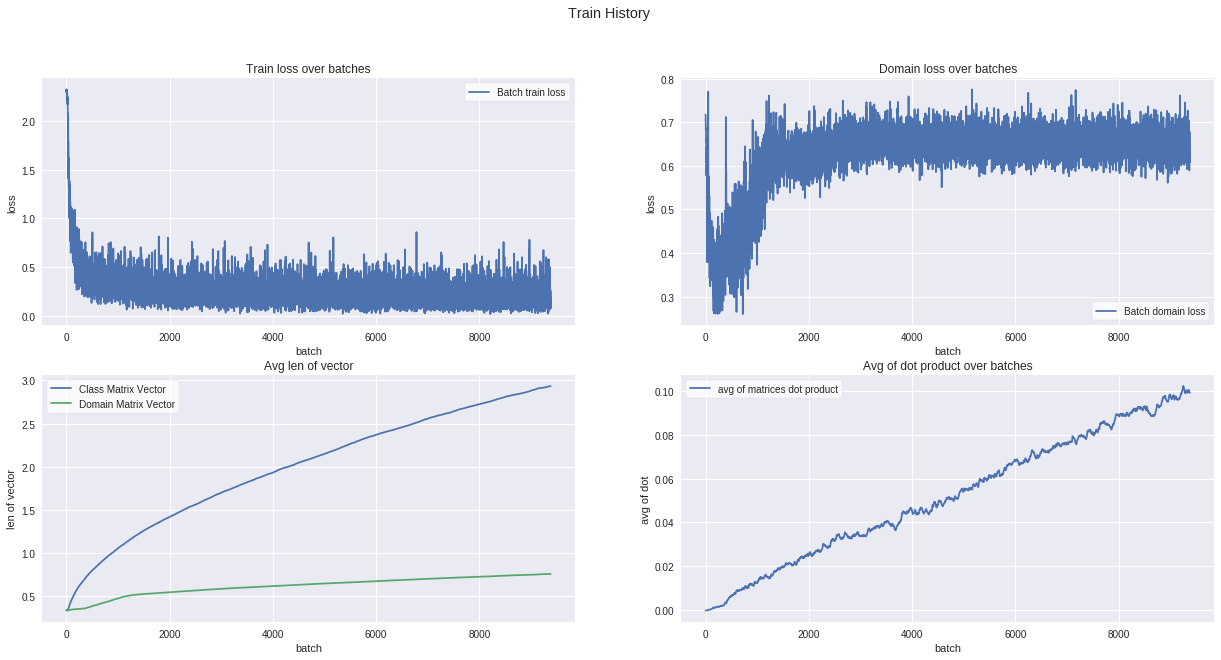

In [35]:
plotTraining(train_history)

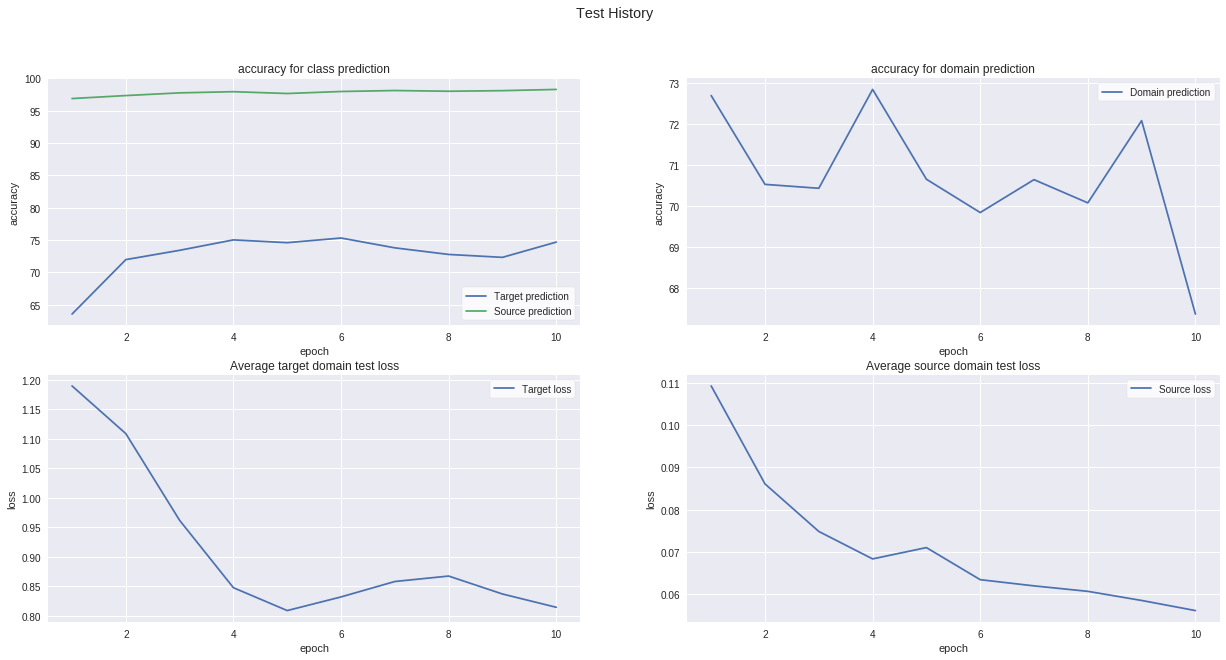

In [36]:
plotTest(test_history)

In [37]:
mnist_pred = nn.Sequential(model_f, model_c)
test(mnist_pred, device, test_loader)


Test set: Average loss: 0.0562, Accuracy: 9828/10000 (98%)



In [0]:
def trainDomain(model_f, model_d, device, train_loader, optimizer, epoch,
               history=True,  model_gr=None, model_c=None, train_history=None):
  model_d.train()
  model_f.eval()
  for batch_idx, (data, (_, domains)) in enumerate(train_loader):
    data, domains = data.to(device), domains.to(device)
    optimizer.zero_grad()
    output = model_d(model_f(data))
    loss = criterion_domain(output, domains)
    loss.backward()
    optimizer.step()
    if history:
      model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()
      model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()
      model_gr_mtx = model_gr.fc1.weight.cpu().detach().numpy()
      train_history['avg_len'].append(np.mean(np.diag(model_d_mtx.dot(model_d_mtx.T))))
      train_history['avg_dot'].append(np.mean(model_d_mtx.dot(model_c_mtx.T)))
      train_history['avg_dot_gr'].append(np.mean(model_d_mtx.dot(model_gr_mtx.T)))
    if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  model_f.zero_grad()

In [0]:
def testDomainPred(model, device, merged_test_loader):
  model.eval()
  
  domain_test_loss = 0
  domain_correct = 0
  
  with torch.no_grad():    
    for data, target in merged_test_loader:
      data = data.to(device)
      _, domains = target
      domains = domains.to(device)
      
      domain_out = model(data)
      domain_pred = domain_out.max(1, keepdim=True)[1] 
      domain_correct += domain_pred.eq(domains.view_as(domain_pred)).sum().item()
      
  domain_test_loss /= len(merged_test_loader.dataset)

  print('\nDomains predictor:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      domain_correct, len(merged_test_loader.dataset),
      100. * domain_correct / len(merged_test_loader.dataset)))

In [0]:
class Domain(nn.Module):
  def __init__(self):
    super(Domain, self).__init__()
    self.fc1 = nn.Linear(320, 100)
    self.fc2 = nn.Linear(100, 2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [0]:
log_interval = 300

In [42]:
epochs=3
domain_train_history = defaultdict(lambda:[])
domain_pred = Domain().to(device)
lr = 0.01
optim_domain = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)
for epoch in range(1, epochs+1):
  trainDomain(model_f, domain_pred, device, mnist_ext_train_loader, optim_domain,
              epoch, True, model_d, model_c, domain_train_history)
  testDomainPred(nn.Sequential(model_f, domain_pred), device, mnist_ext_test_loader)

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.852584
Train Epoch: 1 [19200/120000 (16%)]	Loss: 0.445498
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.486435
Train Epoch: 1 [57600/120000 (48%)]	Loss: 0.632899
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.490690
Train Epoch: 1 [96000/120000 (80%)]	Loss: 0.475786
Train Epoch: 1 [115200/120000 (96%)]	Loss: 0.420554

Domains predictor:  Accuracy: 17127/20000 (86%)

Train Epoch: 2 [0/120000 (0%)]	Loss: 0.438586
Train Epoch: 2 [19200/120000 (16%)]	Loss: 0.441531
Train Epoch: 2 [38400/120000 (32%)]	Loss: 0.485070
Train Epoch: 2 [57600/120000 (48%)]	Loss: 0.422795
Train Epoch: 2 [76800/120000 (64%)]	Loss: 0.399188
Train Epoch: 2 [96000/120000 (80%)]	Loss: 0.350661
Train Epoch: 2 [115200/120000 (96%)]	Loss: 0.292718

Domains predictor:  Accuracy: 17704/20000 (89%)

Train Epoch: 3 [0/120000 (0%)]	Loss: 0.297801
Train Epoch: 3 [19200/120000 (16%)]	Loss: 0.315212
Train Epoch: 3 [38400/120000 (32%)]	Loss: 0.340507
Train Epoch: 3 [57600/120000 (48%)]	Loss: 0.20

In [0]:
def plotDomainTraining(domain_train_history, train_history):
  fig, axs = plt.subplots(1, 3, figsize=(21,5))

  fig.suptitle('Train History')

  histLen = min(len(domain_train_history['avg_len']),
                len(train_history['avg_len_d']))
  model_gr_len_avg = train_history['avg_len_d'][:histLen]
  model_gr_dot_avg = train_history['avg_dot'][:histLen]

  axs[0].plot(np.arange(histLen), domain_train_history['avg_len'][:histLen],
                 label='Domain Net')
  axs[0].plot(np.arange(histLen), model_gr_len_avg,
                 label='Gradient Reverse Net')
  axs[0].set_title('Avg len of vector')
  axs[0].set_ylabel('len')
  axs[0].set_xlabel('epoch')
  axs[0].legend(frameon=True, facecolor='white')

  axs[1].plot(np.arange(histLen), domain_train_history['avg_dot'][:histLen],
                 label='Domain Net')
  axs[1].plot(np.arange(histLen), model_gr_dot_avg,
                 label='Gradient Reverse Net')
  axs[1].set_title('Average of dot product with class net')
  axs[1].set_ylabel('dot product')
  axs[1].set_xlabel('epoch')
  axs[1].legend(frameon=True, facecolor='white')

  axs[2].plot(np.arange(len(domain_train_history['avg_dot_gr'])),
              domain_train_history['avg_dot_gr'], label='Avg dot product')
  axs[2].set_title('Average of dot product with domain GR net')
  axs[2].set_ylabel('dot product')
  axs[2].set_xlabel('epoch')
  axs[2].legend(frameon=True, facecolor='white')


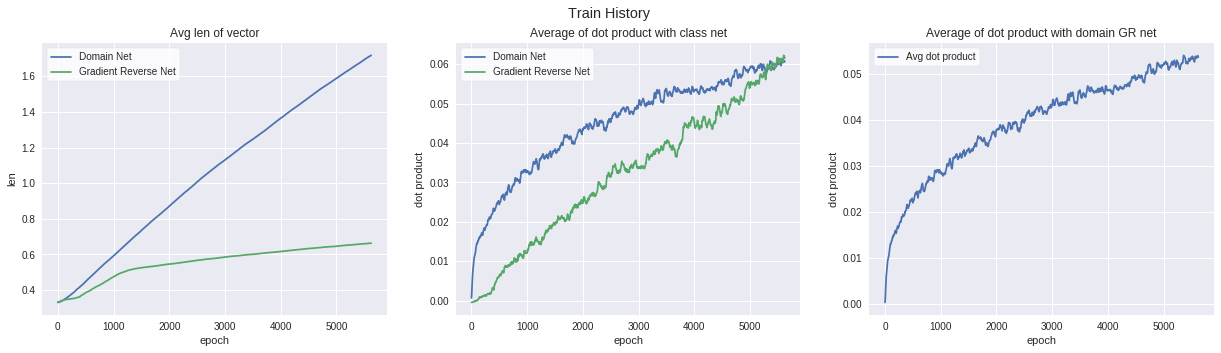

In [44]:
plotDomainTraining(domain_train_history, train_history)

In [0]:
model_c_mtx = model_c.fc1.weight.cpu().detach().numpy()
model_d_mtx = model_d.fc1.weight.cpu().detach().numpy()
domain_pred_mtx = domain_pred.fc1.weight.cpu().detach().numpy()

In [46]:
model_c_mtx.shape

(50, 320)

In [47]:
np.mean(model_c_mtx.dot(model_d_mtx.T))

0.09942728

In [48]:
np.mean(model_c_mtx.dot(domain_pred_mtx.T))

0.060609404

In [49]:
np.sum(domain_pred_mtx.dot(model_d_mtx.T))

537.0748

In [50]:
np.linalg.matrix_rank(np.vstack((model_d_mtx, domain_pred_mtx, model_c_mtx)))

250

In [51]:
_, inds = sympy.Matrix(model_d_mtx).T.rref()
len(inds)

100

In [0]:
log_interval = 100
epochs=7

In [0]:
model_cc = copy.deepcopy(model_c)
model_dc = copy.deepcopy(model_d)
model_fc = copy.deepcopy(model_f)
optim_f = optim.SGD(model_fc.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_cc.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_dc.parameters(), lr=lr, momentum=momentum)

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(model_d.fc1.weight, 0, 1)), 2))

In [55]:
test_history2 = defaultdict(lambda:[])
train_history2 = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  trainWithDomain(model_fc, model_cc, model_dc, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history2, extra_loss=mtx_dot)
  testDomainModel(model_fc, model_cc, model_dc, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history2)

Train Epoch:               1 [0/60000 (0%)]	Loss: 0.153763, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.360274, lr: 0.00899 lambd: 0.07604
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.243084, lr: 0.00819 lambd: 0.15121
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.056570, lr: 0.00754 lambd: 0.22467
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.072775, lr: 0.00700 lambd: 0.29566
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.121217, lr: 0.00654 lambd: 0.36353
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.103518, lr: 0.00614 lambd: 0.42775
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.060119, lr: 0.00580 lambd: 0.48792
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.303238, lr: 0.00550 lambd: 0.54379
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.186510, lr: 0.00523 lambd: 0.59522

Target Domain Test set: Average loss: 0.8411, Accuracy: 7225/10000 (72%)

Source Doma

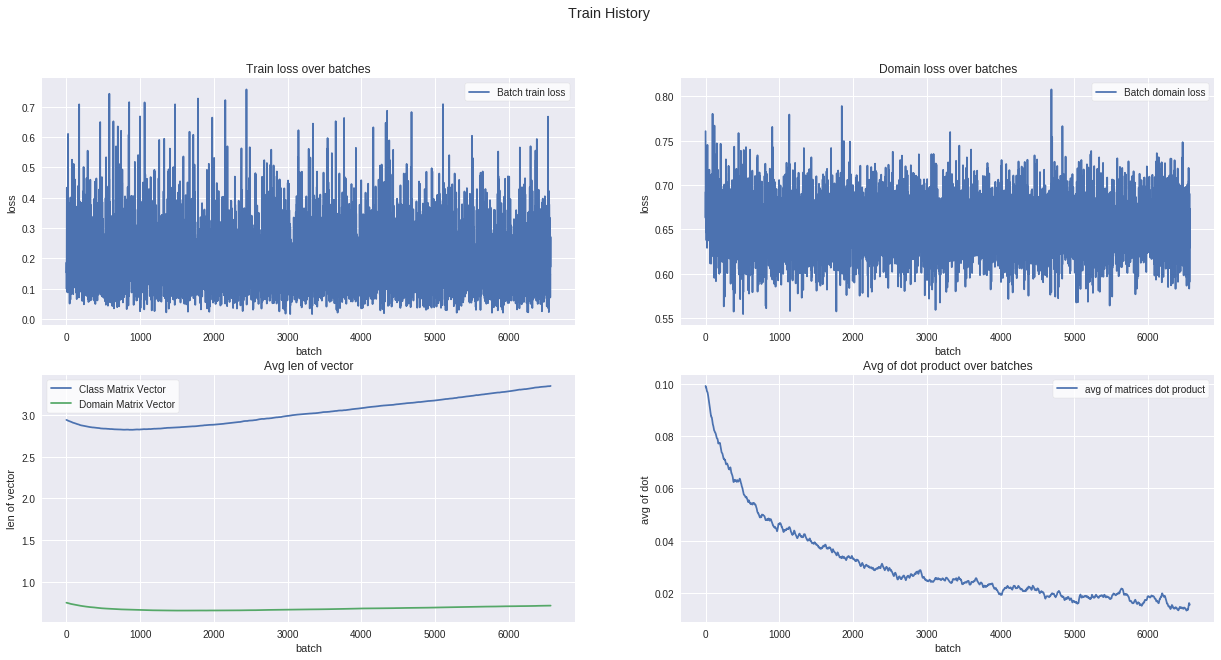

In [56]:
plotTraining(train_history2)

In [0]:
model_cc = copy.deepcopy(model_c)
model_dc = copy.deepcopy(model_d)
model_fc = copy.deepcopy(model_f)
optim_f = optim.SGD(model_fc.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_cc.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_dc.parameters(), lr=lr, momentum=momentum)

In [0]:
def mtx_dot_len(model_c_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.fc1.weight, torch.transpose(
        model_c.fc1.weight, 0, 1)))))
  return f

In [59]:
test_history3 = defaultdict(lambda:[])
train_history3 = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  f = mtx_dot_len(torch.mean(torch.diag(
                     torch.mm(model_c.fc1.weight,
                              torch.transpose(model_c.fc1.weight, 0, 1)))).item())
  trainWithDomain(model_fc, model_cc, model_dc, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history3,
                 extra_loss=f)
  testDomainModel(model_fc, model_cc, model_dc, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history3)

Train Epoch:               1 [0/60000 (0%)]	Loss: 0.298644, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.140955, lr: 0.00899 lambd: 0.07604
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.066917, lr: 0.00819 lambd: 0.15121
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.518251, lr: 0.00754 lambd: 0.22467
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.185432, lr: 0.00700 lambd: 0.29566
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.109316, lr: 0.00654 lambd: 0.36353
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.362915, lr: 0.00614 lambd: 0.42775
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.150088, lr: 0.00580 lambd: 0.48792
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.219557, lr: 0.00550 lambd: 0.54379
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.248112, lr: 0.00523 lambd: 0.59522

Target Domain Test set: Average loss: 0.8407, Accuracy: 7353/10000 (74%)

Source Doma

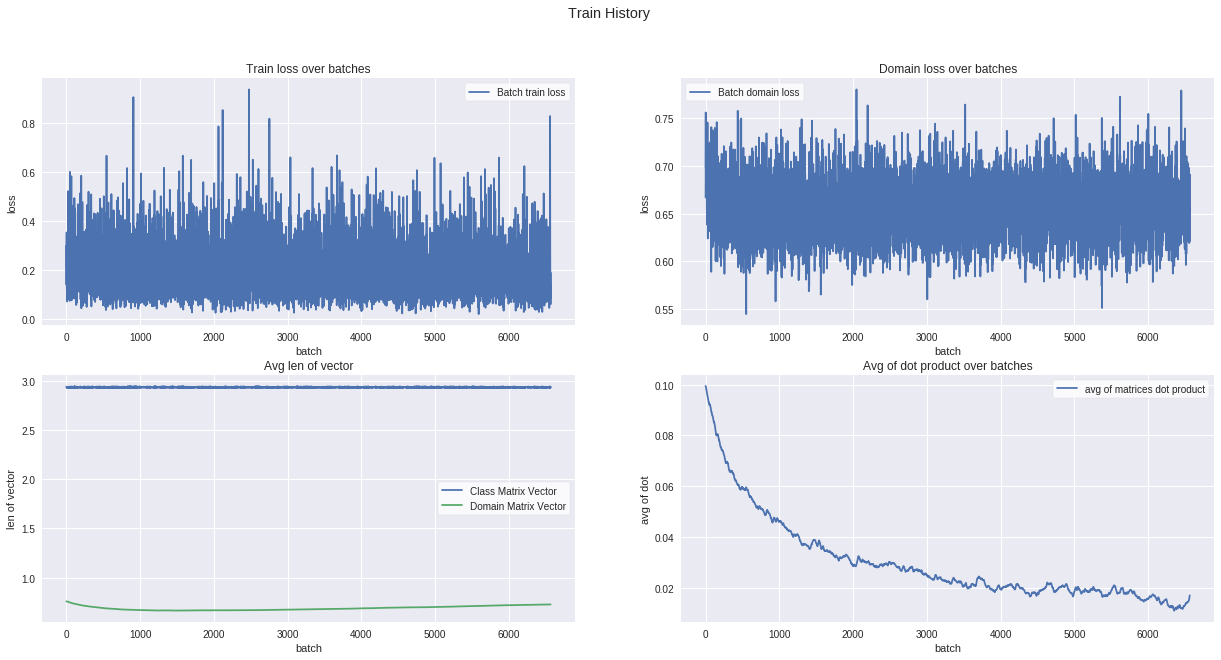

In [60]:
plotTraining(train_history3)

In [0]:
model_cc = copy.deepcopy(model_c)
model_dc = copy.deepcopy(model_d)
model_fc = copy.deepcopy(model_f)
optim_f = optim.SGD(model_fc.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_cc.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_dc.parameters(), lr=lr, momentum=momentum)

In [62]:
test_history4 = defaultdict(lambda:[])
train_history4 = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  f = mtx_dot_len(0)
  trainWithDomain(model_fc, model_cc, model_dc, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history4,
                 extra_loss=f)
  testDomainModel(model_fc, model_cc, model_dc, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history4)

Train Epoch:               1 [0/60000 (0%)]	Loss: 3.135467, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.758370, lr: 0.00899 lambd: 0.07604
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.376918, lr: 0.00819 lambd: 0.15121
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.376365, lr: 0.00754 lambd: 0.22467
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.496958, lr: 0.00700 lambd: 0.29566
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.631369, lr: 0.00654 lambd: 0.36353
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.369220, lr: 0.00614 lambd: 0.42775
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.358977, lr: 0.00580 lambd: 0.48792
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.367791, lr: 0.00550 lambd: 0.54379
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.699708, lr: 0.00523 lambd: 0.59522

Target Domain Test set: Average loss: 0.7451, Accuracy: 7592/10000 (76%)

Source Doma

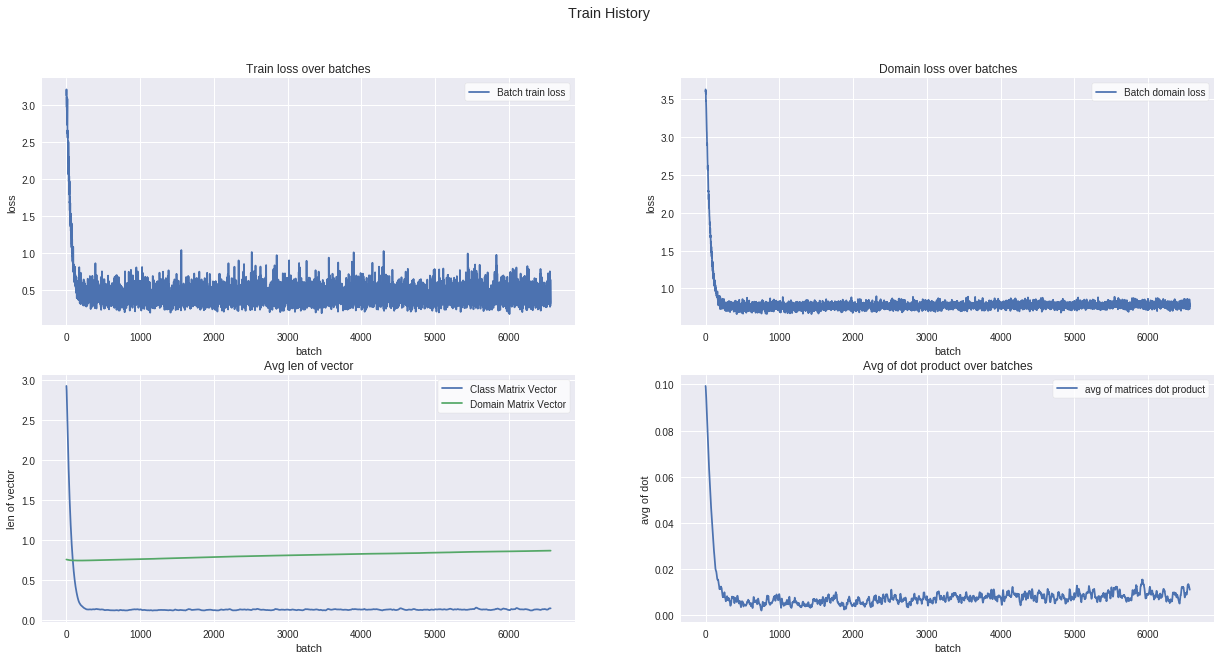

In [63]:
plotTraining(train_history4)

In [0]:
model_cc = copy.deepcopy(model_c)
model_dc = copy.deepcopy(model_d)
model_fc = copy.deepcopy(model_f)
optim_f = optim.SGD(model_fc.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_cc.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_dc.parameters(), lr=lr, momentum=momentum)

In [0]:
def mtx_dot_lens(model_c_len, model_d_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.fc1.weight, torch.transpose(
        model_c.fc1.weight, 0, 1))))) + torch.abs(model_d_len - torch.mean(
        torch.diag(torch.mm(model_d.fc1.weight, torch.transpose(
        model_d.fc1.weight, 0, 1)))))
  return f

In [85]:
test_history6 = defaultdict(lambda:[])
train_history6 = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  f = mtx_dot_lens(0, 0)
  trainWithDomain(model_fc, model_cc, model_dc, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history6,
                 extra_loss=f)
  testDomainModel(model_fc, model_cc, model_dc, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history6)

Train Epoch:               1 [0/60000 (0%)]	Loss: 4.061970, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 1.127256, lr: 0.00899 lambd: 0.07604
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.712448, lr: 0.00819 lambd: 0.15121
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.455159, lr: 0.00754 lambd: 0.22467
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.490101, lr: 0.00700 lambd: 0.29566
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.585555, lr: 0.00654 lambd: 0.36353
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.501322, lr: 0.00614 lambd: 0.42775
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.462465, lr: 0.00580 lambd: 0.48792
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.520727, lr: 0.00550 lambd: 0.54379
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.254456, lr: 0.00523 lambd: 0.59522

Target Domain Test set: Average loss: 0.7625, Accuracy: 7616/10000 (76%)

Source Doma

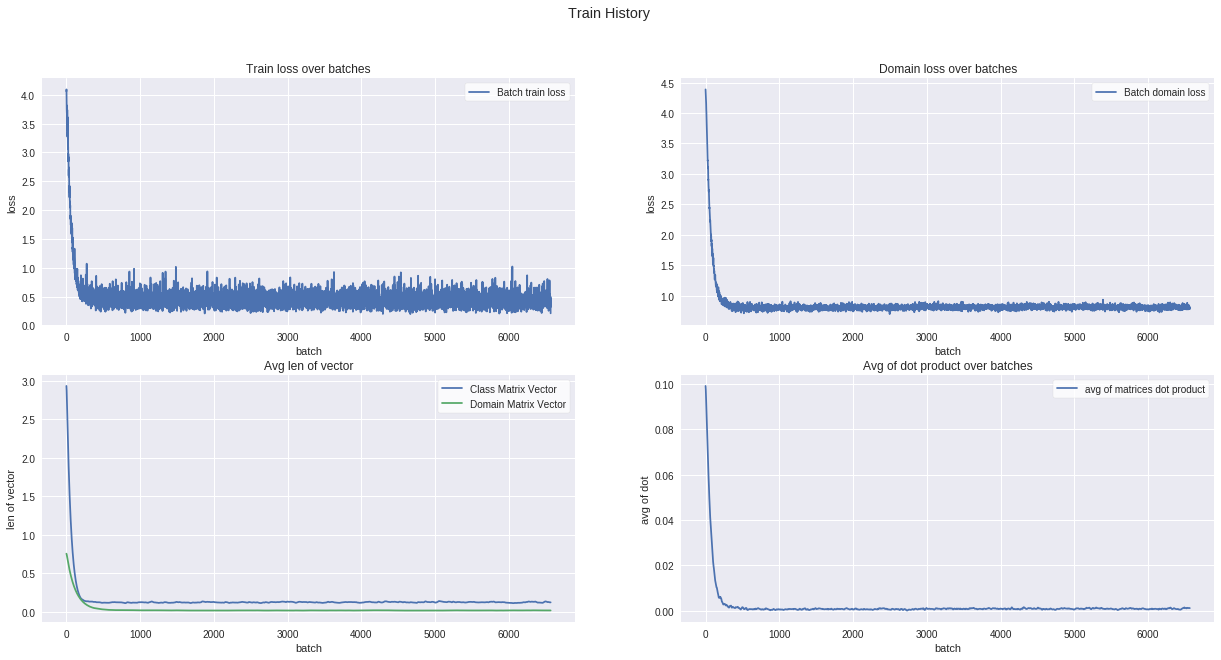

In [86]:
plotTraining(train_history6)

In [0]:
new_gr_model = MnistDomain()
new_gr_model.load_state_dict(domain_pred.state_dict())
new_gr_model = new_gr_model.to(device)

In [65]:
dom_pr = nn.Sequential(model_f, new_gr_model)
testDomainPred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 17901/20000 (90%)



In [0]:
model_cc = copy.deepcopy(model_c)
model_fc = copy.deepcopy(model_f)
optim_f = optim.SGD(model_fc.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_cc.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(new_gr_model.parameters(), lr=lr, momentum=momentum)

In [67]:
test_history5 = defaultdict(lambda:[])
train_history5 = defaultdict(lambda:[])
for epoch in range(1, epochs+1):
  trainWithDomain(model_fc, model_cc, new_gr_model, device,train_loader,
                 mnist_m_train_loader, optim_f, optim_c,
                 optim_d, epoch, epochs, train_domain=True,
                 train_history=train_history5)
  testDomainModel(model_fc, model_cc, new_gr_model, device,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader,
                 test_history=test_history5)

Train Epoch:               1 [0/60000 (0%)]	Loss: 0.183277, lr: 0.01000 lambd: 0.00000
Train Epoch:               1 [6400/60000 (11%)]	Loss: 0.321781, lr: 0.00899 lambd: 0.07604
Train Epoch:               1 [12800/60000 (21%)]	Loss: 0.202947, lr: 0.00819 lambd: 0.15121
Train Epoch:               1 [19200/60000 (32%)]	Loss: 0.183278, lr: 0.00754 lambd: 0.22467
Train Epoch:               1 [25600/60000 (43%)]	Loss: 0.183969, lr: 0.00700 lambd: 0.29566
Train Epoch:               1 [32000/60000 (53%)]	Loss: 0.237874, lr: 0.00654 lambd: 0.36353
Train Epoch:               1 [38400/60000 (64%)]	Loss: 0.157483, lr: 0.00614 lambd: 0.42775
Train Epoch:               1 [44800/60000 (75%)]	Loss: 0.200137, lr: 0.00580 lambd: 0.48792
Train Epoch:               1 [51200/60000 (85%)]	Loss: 0.064960, lr: 0.00550 lambd: 0.54379
Train Epoch:               1 [57600/60000 (96%)]	Loss: 0.064172, lr: 0.00523 lambd: 0.59522

Target Domain Test set: Average loss: 0.8299, Accuracy: 7370/10000 (74%)

Source Doma

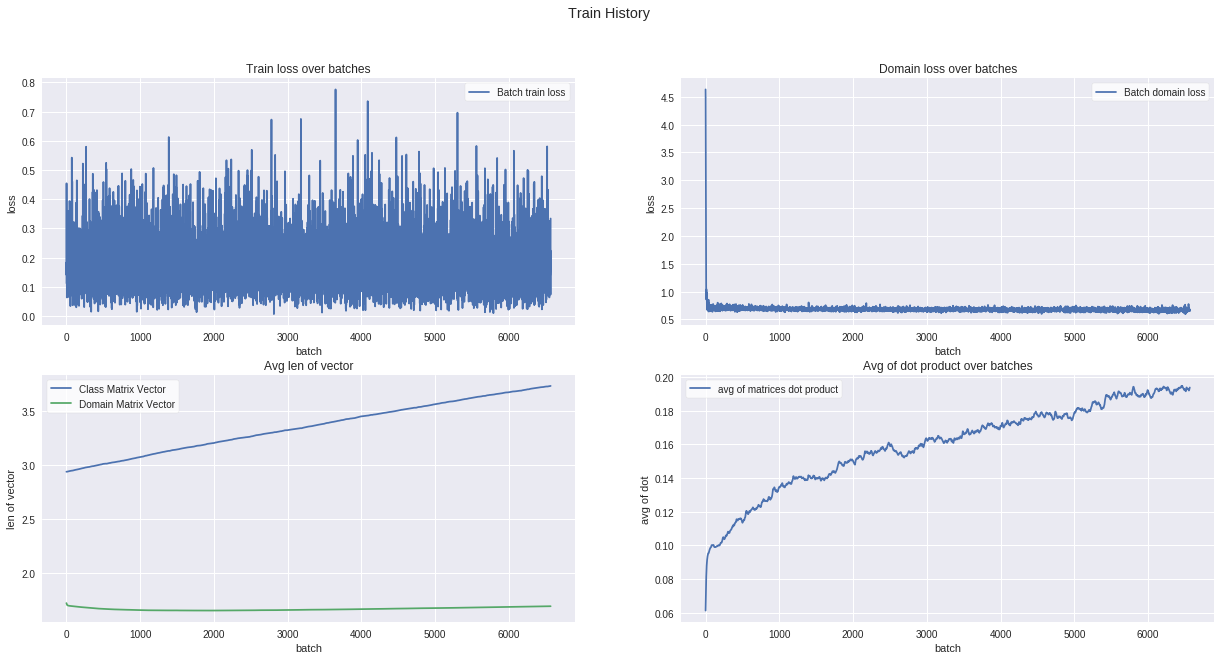

In [68]:
plotTraining(train_history5)

In [69]:
dom_pr = nn.Sequential(model_fc, new_gr_model)
testDomainPred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 13374/20000 (67%)



In [70]:
dom_pr = nn.Sequential(model_fc, domain_pred)
testDomainPred(dom_pr, device, mnist_ext_test_loader)


Domains predictor:  Accuracy: 9441/20000 (47%)



In [71]:
epochs=3
domain_train_history2 = defaultdict(lambda:[])
domain_pred2 = Domain().to(device)
lr = 0.01
optim_domain = optim.SGD(domain_pred2.parameters(), lr=lr, momentum=momentum)
for epoch in range(1, epochs+1):
  trainDomain(model_fc, domain_pred2, device, mnist_ext_train_loader, optim_domain,
              epoch, True, model_dc, model_cc, domain_train_history2)
  testDomainPred(nn.Sequential(model_fc, domain_pred2), device, mnist_ext_test_loader)

Train Epoch: 1 [0/120000 (0%)]	Loss: 0.747281
Train Epoch: 1 [6400/120000 (5%)]	Loss: 0.431410
Train Epoch: 1 [12800/120000 (11%)]	Loss: 0.511081
Train Epoch: 1 [19200/120000 (16%)]	Loss: 0.458970
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.372875
Train Epoch: 1 [32000/120000 (27%)]	Loss: 0.356760
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.365907
Train Epoch: 1 [44800/120000 (37%)]	Loss: 0.338447
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.499500
Train Epoch: 1 [57600/120000 (48%)]	Loss: 0.319632
Train Epoch: 1 [64000/120000 (53%)]	Loss: 0.296455
Train Epoch: 1 [70400/120000 (59%)]	Loss: 0.346217
Train Epoch: 1 [76800/120000 (64%)]	Loss: 0.348943
Train Epoch: 1 [83200/120000 (69%)]	Loss: 0.220742
Train Epoch: 1 [89600/120000 (75%)]	Loss: 0.314233
Train Epoch: 1 [96000/120000 (80%)]	Loss: 0.350926
Train Epoch: 1 [102400/120000 (85%)]	Loss: 0.358386
Train Epoch: 1 [108800/120000 (91%)]	Loss: 0.471914
Train Epoch: 1 [115200/120000 (96%)]	Loss: 0.203740

Domains predictor:  Accuracy: 1798

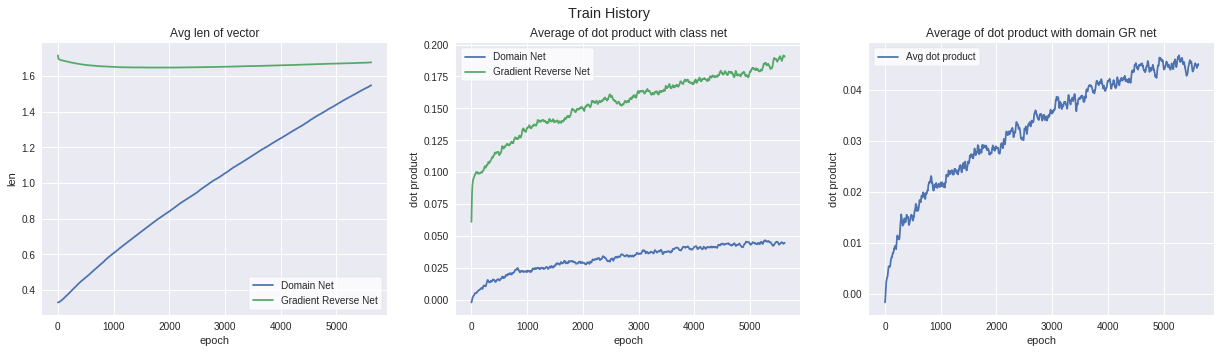

In [72]:
plotDomainTraining(domain_train_history2, train_history5)

In [0]:
# Tests from different training methods

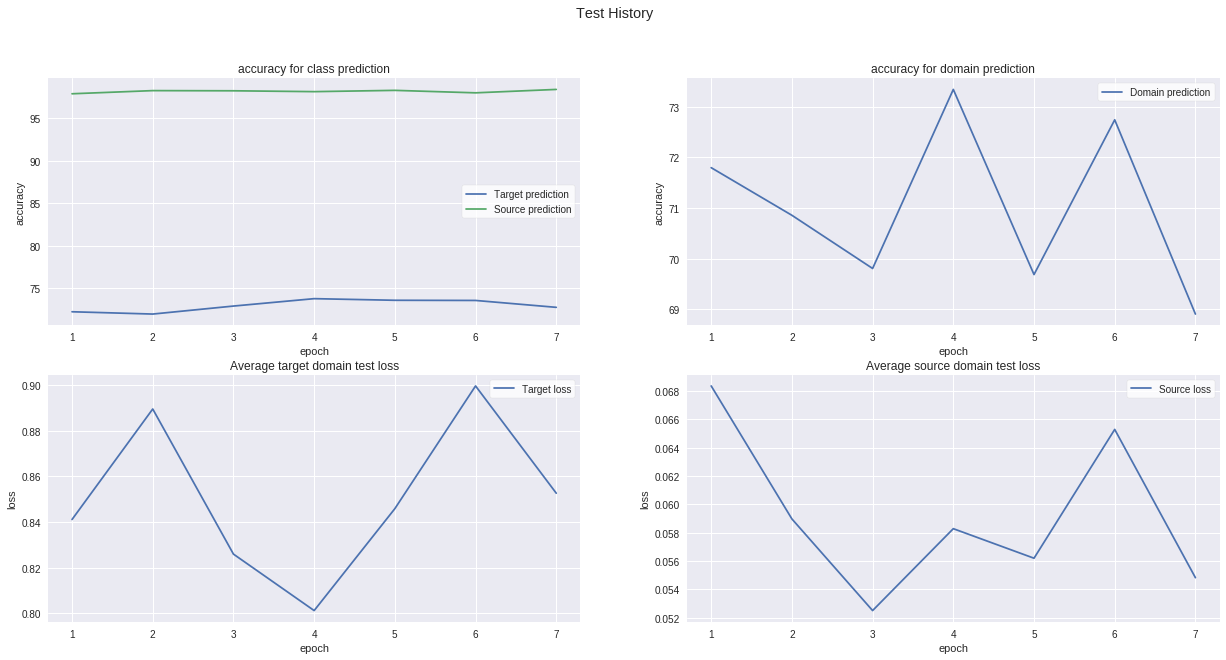

In [76]:
plotTest(test_history2)

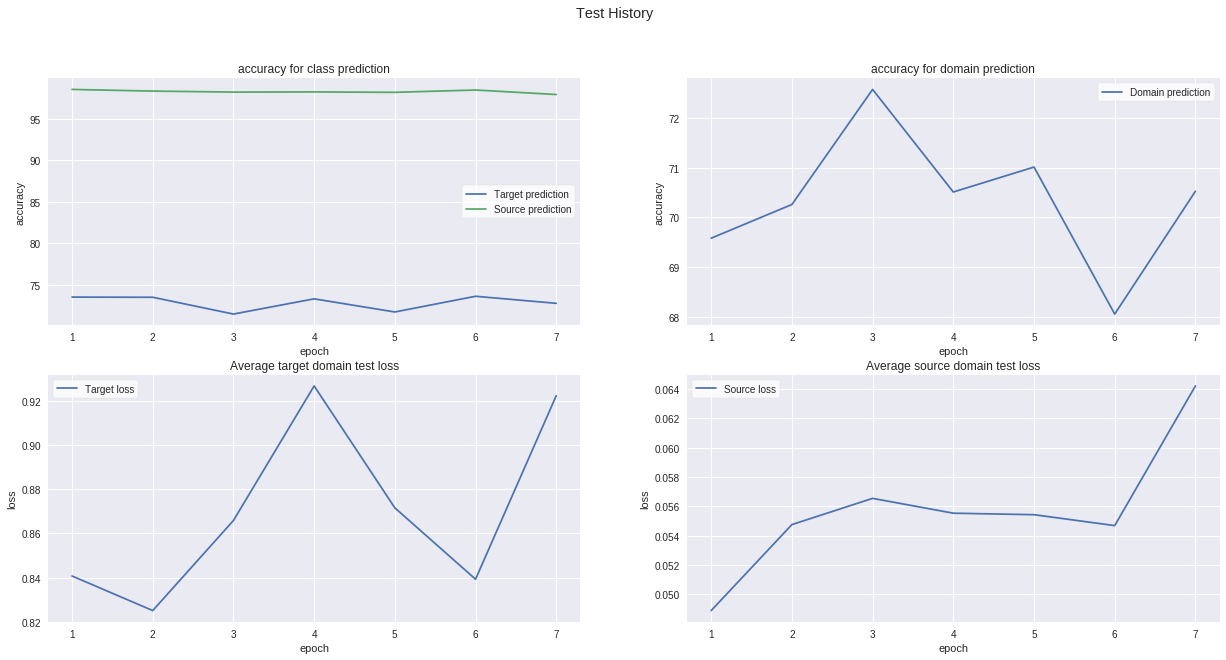

In [77]:
plotTest(test_history3)

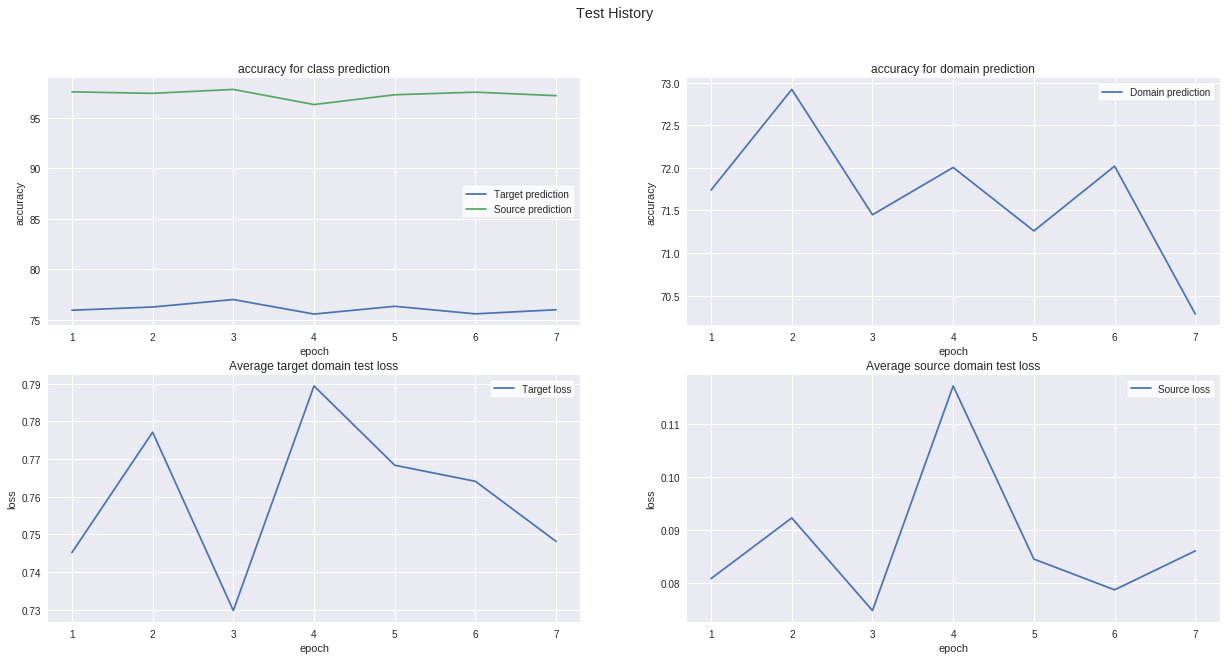

In [78]:
plotTest(test_history4)

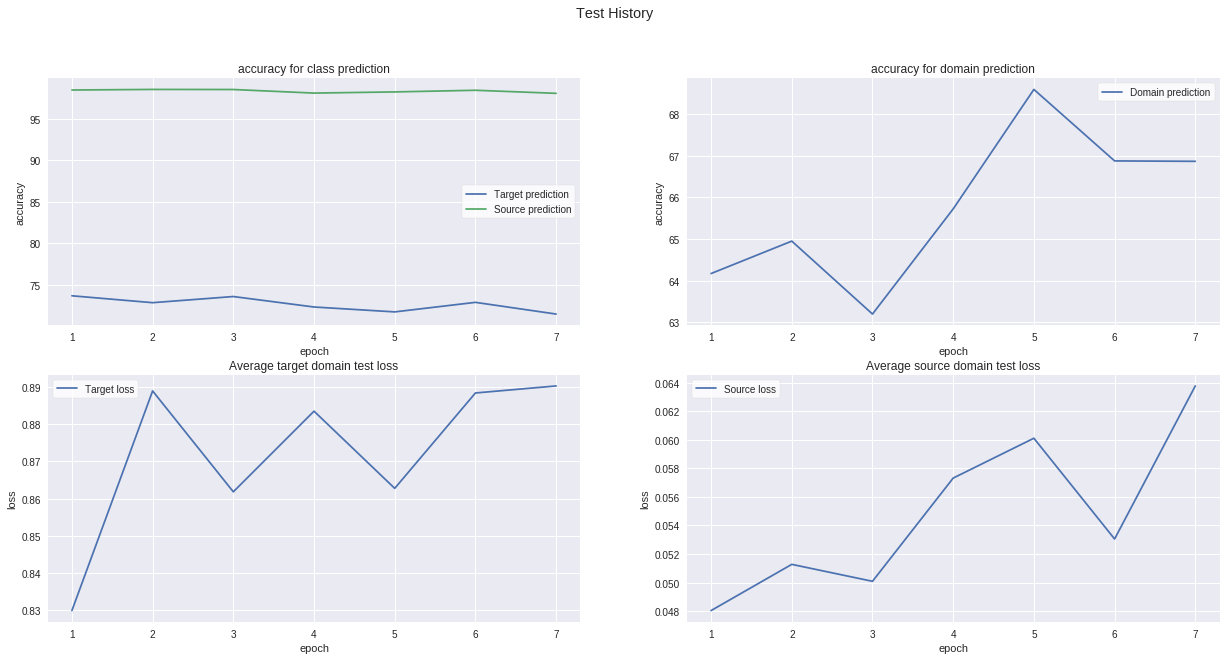

In [79]:
plotTest(test_history5)

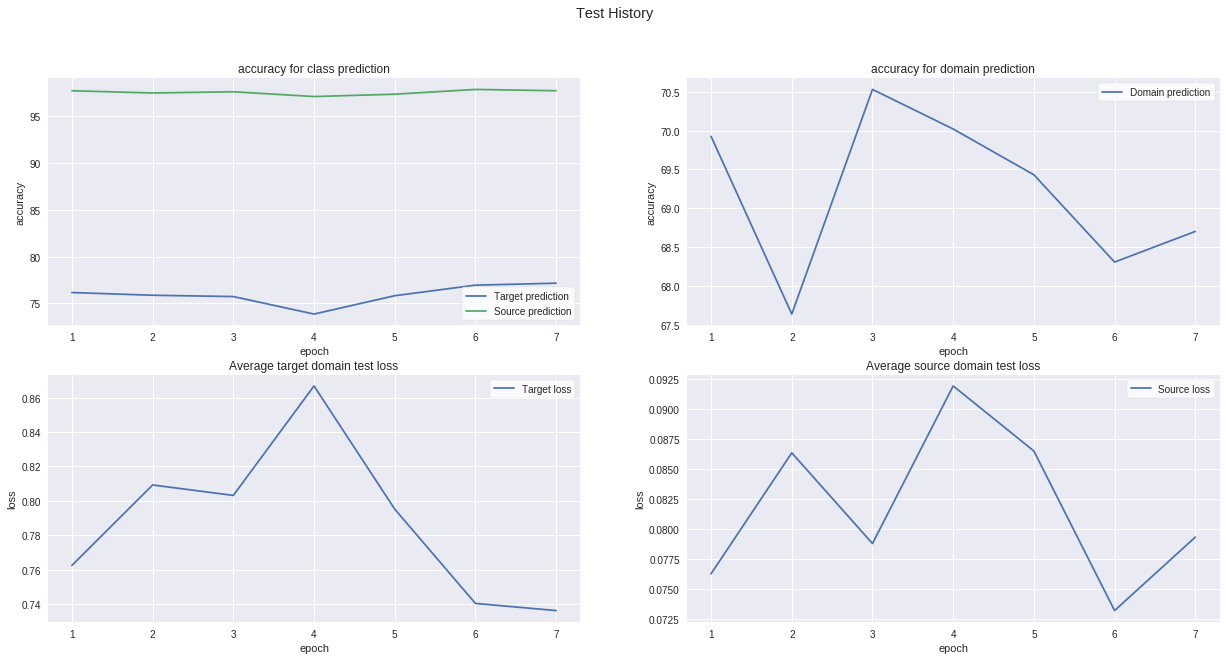

In [88]:
plotTest(test_history6)

In [96]:
#After training with minimalizing lens of model_c and model_d matrices
model_cc_mtx = model_cc.fc1.weight.cpu().detach().numpy()
model_dc_mtx = model_dc.fc1.weight.cpu().detach().numpy()
model_cc_mtx.dot(model_dc_mtx.T)

array([[-0.0058084 ,  0.00247772,  0.00610721, ...,  0.00591231,
         0.00427343,  0.00020218],
       [ 0.00259059,  0.01078497, -0.00405448, ..., -0.00806331,
         0.00211006, -0.01002197],
       [ 0.00234873,  0.00236034,  0.00493381, ...,  0.01800501,
         0.005596  ,  0.0190874 ],
       ...,
       [ 0.00976153, -0.00041839,  0.00042611, ..., -0.00558626,
        -0.00250461, -0.00113232],
       [ 0.00383369, -0.00583437,  0.00422643, ..., -0.00993408,
         0.00071994, -0.00781831],
       [ 0.00446413,  0.00050264,  0.00804295, ...,  0.02643069,
         0.0089151 ,  0.01803168]], dtype=float32)

In [95]:
np.mean(model_cc_mtx.dot(model_dc_mtx.T))

0.0011198681